<h1>Levenberg-Marquardt Algorithm Tensorflow Based Implementation</h1>
<h2>Introduction</h2>
The Levenberg-Marquardt (LM) algorithm is the most widely used optimization algorithm. It outperforms simple gradient descent and other conjugate gradient methods in a wide variety of problems. This tutorial demonstrates LM implementation using Tensorflow to optimize MLP neural networks.
<h2>Imports</h2>

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
%matplotlib inline

C:\Python64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<h2>Rosenbrock function</h2>
We will use Rosenbrock function as performance test problem. Let's start with its two variables form: <i>f(x, y) = (a - x)^2 + b(y - x^2)^2</i>.

In [2]:
def rosenbrock(x, y, a, b):
    return (a - x)**2 + b*(y - x**2)**2

# consider this function on the square [-2,2]x[-2,2]
x_grid, y_grid = np.meshgrid(np.arange(-2, 2.1, 0.1), 
                             np.arange(-2, 2.1, 0.1))
# with parameters a = 0.5 and b = 0.5
z_grid = rosenbrock(x_grid, y_grid, 0.5, 0.5)

<h2>Helper-function for plotting images</h2>

In [3]:
GRAY1 = '#646369'
BLUE1, BLUE2 = '#4A81BF', '#174A7E'

def prepare_3d_plot_for_rosenbrock():
    fig = plt.figure(figsize=(7, 5), dpi=110)
    ax = fig.add_subplot(111, projection='3d')
    # configure tick labels appearance
    for i in ax.get_yticklabels() + ax.get_xticklabels() + ax.get_zticklabels():
        i.set_fontsize(8)
        i.set_color(GRAY1)
    ax.view_init(40, 80)
    return ax

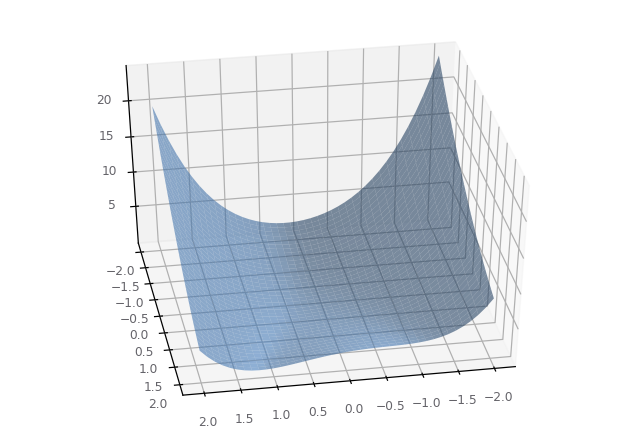

In [5]:
# let's plot it
ax = prepare_3d_plot_for_rosenbrock()
ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.6, color=BLUE1)

<h2>The Problem</h2>
The problem for which the LM algorithm provides a solution is called <i>Nonlinear Least Squares Minimization</i>. Suppose from an experiment we have as set of <i>m</i> data points, <i>(x1, y1, z1), (x2, y2, z2),..., (xm, ym, zm)</i>. Our goal is to be able to predict <i>z</i> for other values <i>(x, y)</i>. We have a model function <i>z = rosenbrock(x, y, a, b)</i>, that in addition to the variables <i>(x, y)</i> also depends on parameters <i>a, b</i>. It is desired to find these parameters such that the surface fits best the given data in the least squares sense.

In [6]:
# generate some data points from an "experiment"
data_points = np.array([[x, y, rosenbrock(x, y, 0.5, 0.5)]
                       for x in np.arange(-2, 2.1, 2) 
                       for y in np.arange(-2, 2.1, 2)])
m = data_points.shape[0]

# now, please, forget about actual paramenters (0.5, 0.5)
# suppose they are unknown and our goal is to estimate them 
# using only data_points and knowledge knowledge about our model

# we start with guessing
a_guess, b_guess = 5, 5
# predictions usually have -hat suffix
z_hat = rosenbrock(data_points[:,0], data_points[:,1], a_guess, b_guess)
# residual is the difference between the measured value and the predicted value
r = data_points[:,2] - z_hat
# calculate the squared residuals sum in one line of code
# by multiplying a row vectory by itself column vector
loss = r.dot(r.T)
# our guess is bad :(. Let's try another guess?
print(loss)

98339.0625


<h2>The Problem Graphical Representation</h2>
We can plot the data points from the experiment as dots, our model as a suface and the residuals as lines connecting data dots to the model surface. See how far the data points are from the model. We need to find better <i>a, b</i> to make it closer.

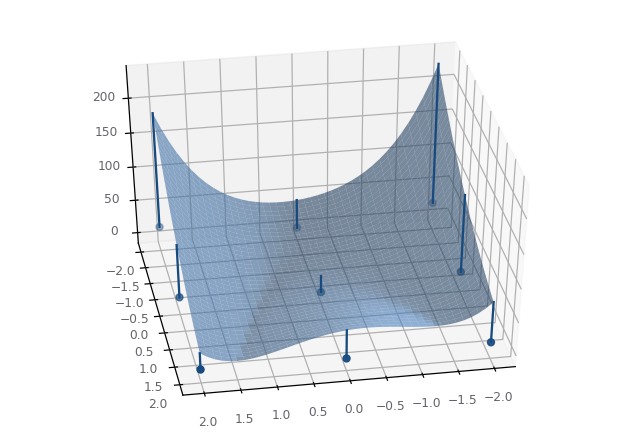

In [8]:
ax = prepare_3d_plot_for_rosenbrock()
# plot data points from an experiment
ax.scatter(data_points[:,0], 
           data_points[:,1], 
           data_points[:,2], 
           color=BLUE2)
# plot our model surface 
z_hat_grid = rosenbrock(x_grid, y_grid, a_guess, b_guess)
ax.plot_surface(x_grid, y_grid, z_hat_grid, alpha=0.6, color=BLUE1)
# plot residuals as lines
for i in range(m):
    ax.plot([data_points[i, 0], data_points[i, 0]], 
            [data_points[i, 1], data_points[i, 1]], 
            [data_points[i, 2], z_hat[i]], c=BLUE2)

<h2>Tensorflow Problem Definition</h2>
From now we start using more common convention for naming. Instead of z = f(x, y, a, b).